# Fish Dataset Metadata Analysis for Mixture of Experts

This notebook analyzes the available metadata and labels in the fish dataset to help choose features for a Mixture of Experts (MoE) model.

## Objectives:
1. Load and explore all metadata columns
2. Analyze taxonomic hierarchy (Order, Family)
3. Examine class distributions and balance
4. Generate recommendations for MoE routing features
5. Visualize metadata distributions


In [18]:
# Import required libraries
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## 1. Load Metadata

In [19]:
# Load metadata CSV
metadata_path = '../datasets/anns/train_full_meta_new.csv'
metadata_df = pd.read_csv(metadata_path)

print(f"✓ Loaded metadata from: {metadata_path}")
print(f"  Total records: {len(metadata_df)}")
print(f"  Total columns: {len(metadata_df.columns)}")
print(f"\nFirst few rows:")
metadata_df.head()

✓ Loaded metadata from: ../datasets/anns/train_full_meta_new.csv
  Total records: 463
  Total columns: 9

First few rows:


,Unnamed: 0.1,Unnamed: 0,Family_cls,Family,Order,fam_info,ord_info,Order_cls,Order_new
0,0,0,0,Labridae,Perciformes,0,0.0,27,Perciformes
1,1,1,1,Pomacentridae,Ovalentaria,0,1.0,6,Ovalentaria
2,2,2,2,Cyprinidae,Cypriniformes,0,1.0,57,Cypriniformes
3,3,3,3,Centrarchidae,Perciformes,0,0.0,27,Perciformes
4,4,4,4,Gobiidae,Gobiiformes,0,1.0,59,Gobiiformes


In [20]:
# Load fish summary JSON (species descriptions)
json_path = '../datasets/anns/fish_summary.json'
with open(json_path, 'r') as f:
    fish_summary = json.load(f)

print(f"✓ Loaded fish summary JSON: {json_path}")
print(f"  Total species descriptions: {len(fish_summary)}")
print(f"\nExample species description:")
first_species = list(fish_summary.keys())[0]
print(f"\nSpecies: {first_species}")
print(f"Description: {fish_summary[first_species][:300]}...")

# Load train and test CSV files (main dataset files)
train_path = '../datasets/anns/train.csv'
test_path = '../datasets/anns/test.csv'

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

print(f"\n{'='*80}")
print(f"✓ Loaded train.csv: {train_path}")
print(f"  Total records: {len(train_df)}")
print(f"  Total columns: {len(train_df.columns)}")

print(f"\n✓ Loaded test.csv: {test_path}")
print(f"  Total records: {len(test_df)}")
print(f"  Total columns: {len(test_df.columns)}")

print(f"\nTotal dataset size: {len(train_df) + len(test_df)} samples")
print(f"Train/Test split: {len(train_df)}/{len(test_df)} = {len(train_df)/(len(train_df)+len(test_df))*100:.1f}%/{len(test_df)/(len(train_df)+len(test_df))*100:.1f}%")

✓ Loaded fish summary JSON: ../datasets/anns/fish_summary.json
  Total species descriptions: 17393

Example species description:

Species: Microgobius curtus
Description: The species *Microgobius curtus* is characterized by its elongated body shape and light grey-brown coloration, accented with bright iridescent blue and yellow areas. The body is laterally compressed and completely scaled. It features a large, nearly vertical mouth, and its first dorsal fin has seven...

✓ Loaded train.csv: ../datasets/anns/train.csv
  Total records: 75631
  Total columns: 25

✓ Loaded test.csv: ../datasets/anns/test.csv
  Total records: 18901
  Total columns: 25

Total dataset size: 94532 samples
Train/Test split: 75631/18901 = 80.0%/20.0%

✓ Loaded train.csv: ../datasets/anns/train.csv
  Total records: 75631
  Total columns: 25

✓ Loaded test.csv: ../datasets/anns/test.csv
  Total records: 18901
  Total columns: 25

Total dataset size: 94532 samples
Train/Test split: 75631/18901 = 80.0%/20.0%


### 1.1 Explore Train/Test CSV Columns

The train.csv and test.csv files contain rich metadata about each fish sample.

In [21]:
# Display all available columns in train.csv
print("=" * 100)
print("ALL COLUMNS IN TRAIN.CSV")
print("=" * 100)
print(f"\nTotal columns: {len(train_df.columns)}\n")

for i, col in enumerate(train_df.columns, 1):
    print(f"{i:2d}. {col}")

print("\n" + "=" * 100)
print("FIRST FEW ROWS OF TRAIN.CSV")
print("=" * 100)
train_df.head()

ALL COLUMNS IN TRAIN.CSV

Total columns: 25

 1. Unnamed: 0.1
 2. Unnamed: 0
 3. species
 4. image
 5. SpecCode
 6. Genus
 7. Subfamily
 8. Family
 9. Order
10. Class
11. SuperClass
12. source
13. Folder
14. Troph
15. FeedingPath
16. Tropical
17. Temperate
18. Subtropical
19. Boreal
20. Polar
21. freshwater
22. saltwater
23. brackish
24. NewOrder
25. Frequency

FIRST FEW ROWS OF TRAIN.CSV


,Unnamed: 0.1,Unnamed: 0,species,image,SpecCode,Genus,Subfamily,Family,Order,Class,...,Tropical,Temperate,Subtropical,Boreal,Polar,freshwater,saltwater,brackish,NewOrder,Frequency
0,61488,61488,NaN,1cc71197-f08c-4f99-acf1-623327a89077.jpg,NaN,Diplodus,NaN,Sparidae,Perciformes,Actinopterygii,...,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,Perciformes,0.280692
1,21901,21901,NaN,aa3ca308-f595-4019-8bff-422c3350a65a.jpg,NaN,Aplodinotus,NaN,Sciaenidae,Perciformes,Actinopterygii,...,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,Perciformes,0.280692
2,21912,21912,Pareques iwamotoi,https://www.fishbase.se/images/species/Eqiwa_u...,4660.0,Pareques,NaN,Sciaenidae,Eupercaria/misc,Actinopteri,...,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,Perciformes,0.280692
3,21911,21911,Nibea maculata,https://www.fishbase.se/images/species/Nimac_u...,11003.0,Nibea,NaN,Sciaenidae,Eupercaria/misc,Actinopteri,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,Perciformes,0.280692
4,21910,21910,NaN,3b162191-0a8a-4de7-887e-5c7d79ac36e8.jpg,NaN,Pogonias,NaN,Sciaenidae,Perciformes,Actinopterygii,...,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,Perciformes,0.280692


In [22]:
# Detailed analysis of each column in train.csv
print("=" * 100)
print("DETAILED COLUMN ANALYSIS - TRAIN.CSV")
print("=" * 100)

train_column_info = []

for col in train_df.columns:
    unique_vals = train_df[col].nunique()
    missing = train_df[col].isna().sum()
    dtype = train_df[col].dtype
    
    train_column_info.append({
        'Column': col,
        'Type': str(dtype),
        'Unique': unique_vals,
        'Missing': missing,
        'Missing %': f"{missing/len(train_df)*100:.2f}%",
        'Sample Values': str(train_df[col].dropna().iloc[0] if len(train_df[col].dropna()) > 0 else 'N/A')[:50]
    })
    
    print(f"\n{'─'*100}")
    print(f"Column: {col}")
    print(f"{'─'*100}")
    print(f"  Data Type: {dtype}")
    print(f"  Unique Values: {unique_vals:,}")
    print(f"  Missing Values: {missing:,} ({missing/len(train_df)*100:.2f}%)")
    
    # Show value distribution for categorical columns
    if unique_vals < 50 and unique_vals > 1:
        print(f"  Value Distribution (Top 10):")
        value_counts = train_df[col].value_counts().head(10)
        for val, count in value_counts.items():
            print(f"    • {val}: {count:,} ({count/len(train_df)*100:.2f}%)")
    elif unique_vals <= 1:
        print(f"  Single Value: {train_df[col].dropna().iloc[0] if len(train_df[col].dropna()) > 0 else 'N/A'}")
    else:
        print(f"  Sample Values: {list(train_df[col].dropna().unique()[:5])}")

# Create summary DataFrame
train_col_summary = pd.DataFrame(train_column_info)
print("\n" + "=" * 100)
print("COLUMN SUMMARY TABLE")
print("=" * 100)
train_col_summary

DETAILED COLUMN ANALYSIS - TRAIN.CSV

────────────────────────────────────────────────────────────────────────────────────────────────────
Column: Unnamed: 0.1
────────────────────────────────────────────────────────────────────────────────────────────────────
  Data Type: int64
  Unique Values: 75,631
  Missing Values: 0 (0.00%)
  Sample Values: [np.int64(61488), np.int64(21901), np.int64(21912), np.int64(21911), np.int64(21910)]

────────────────────────────────────────────────────────────────────────────────────────────────────
Column: Unnamed: 0
────────────────────────────────────────────────────────────────────────────────────────────────────
  Data Type: int64
  Unique Values: 75,631
  Missing Values: 0 (0.00%)
  Sample Values: [np.int64(61488), np.int64(21901), np.int64(21912), np.int64(21911), np.int64(21910)]

────────────────────────────────────────────────────────────────────────────────────────────────────
Column: species
───────────────────────────────────────────────────

,Column,Type,Unique,Missing,Missing %,Sample Values
0,Unnamed: 0.1,int64,75631,0,0.00%,61488
1,Unnamed: 0,int64,75631,0,0.00%,61488
2,species,object,15703,40600,53.68%,Pareques iwamotoi
3,image,object,75631,0,0.00%,1cc71197-f08c-4f99-acf1-623327a89077.jpg
4,SpecCode,float64,15544,40939,54.13%,4660.0
5,Genus,object,3668,339,0.45%,Diplodus
6,Subfamily,object,332,53118,70.23%,Acanthurinae
7,Family,object,463,0,0.00%,Sparidae
8,Order,object,92,0,0.00%,Perciformes
9,Class,object,8,339,0.45%,Actinopterygii


### 1.2 New Metadata Features for MoE

Let's identify the most useful metadata columns from train.csv for MoE routing.

In [ ]:
# Identify categorical metadata features suitable for MoE
print("=" * 100)
print("🎯 ADDITIONAL METADATA FEATURES FOR MOE (from train.csv)")
print("=" * 100)

moe_features = []

# 1. Taxonomic hierarchy
taxonomic_cols = ['Class', 'SuperClass', 'Order', 'Family', 'Subfamily', 'Genus', 'species']
print("\n1️⃣  TAXONOMIC HIERARCHY")
print("─" * 100)
for col in taxonomic_cols:
    if col in train_df.columns:
        unique = train_df[col].nunique()
        missing = train_df[col].isna().sum()
        print(f"  • {col:15s}: {unique:5d} unique values, {missing:6d} missing ({missing/len(train_df)*100:5.2f}%)")
        if col in ['Class', 'SuperClass', 'Order', 'Family']:
            moe_features.append({
                'Category': 'Taxonomic',
                'Feature': col,
                'Unique Values': unique,
                'Missing %': f"{missing/len(train_df)*100:.2f}%",
                'Suitability': 'HIGH' if unique < 100 else 'MEDIUM'
            })

# 2. Ecological features
ecological_cols = ['Tropical', 'Temperate', 'Subtropical', 'Boreal', 'Polar', 
                   'freshwater', 'saltwater', 'brackish']
print("\n2️⃣  ECOLOGICAL/HABITAT FEATURES")
print("─" * 100)
for col in ecological_cols:
    if col in train_df.columns:
        unique = train_df[col].nunique()
        missing = train_df[col].isna().sum()
        value_dist = train_df[col].value_counts().to_dict()
        print(f"  • {col:15s}: {unique:2d} unique values, Distribution: {value_dist}")
        moe_features.append({
            'Category': 'Ecological',  
            'Feature': col,
            'Unique Values': unique,
            'Missing %': f"{missing/len(train_df)*100:.2f}%",
            'Suitability': 'MEDIUM' if unique == 2 else 'LOW'
        })

# 3. Trophic and feeding features
feeding_cols = ['Troph', 'FeedingPath']
print("\n3️⃣  TROPHIC/FEEDING FEATURES")
print("─" * 100)
for col in feeding_cols:
    if col in train_df.columns:
        unique = train_df[col].nunique()
        missing = train_df[col].isna().sum()
        print(f"  • {col:15s}: {unique:5d} unique values, {missing:6d} missing ({missing/len(train_df)*100:5.2f}%)")
        if missing / len(train_df) < 0.5:  # Less than 50% missing
            top_values = train_df[col].value_counts().head(5)
            print(f"    Top values: {dict(top_values)}")
            moe_features.append({
                'Category': 'Feeding',
                'Feature': col,
                'Unique Values': unique,
                'Missing %': f"{missing/len(train_df)*100:.2f}%",
                'Suitability': 'MEDIUM' if unique < 50 else 'LOW'
            })

# 4. Other features
other_cols = ['source', 'Frequency', 'NewOrder']
print("\n4️⃣  OTHER FEATURES")
print("─" * 100)
for col in other_cols:
    if col in train_df.columns:
        unique = train_df[col].nunique()
        missing = train_df[col].isna().sum()
        print(f"  • {col:15s}: {unique:5d} unique values, {missing:6d} missing ({missing/len(train_df)*100:5.2f}%)")
        if unique < 100:
            top_values = train_df[col].value_counts().head(5)
            print(f"    Top values: {dict(top_values)}")
            moe_features.append({
                'Category': 'Other',
                'Feature': col,
                'Unique Values': unique,
                'Missing %': f"{missing/len(train_df)*100:.2f}%",
                'Suitability': 'MEDIUM' if unique < 50 else 'LOW'
            })

print("\n" + "=" * 100)
moe_features_df = pd.DataFrame(moe_features)
moe_features_df

🎯 ADDITIONAL METADATA FEATURES FOR MOE (from train.csv)

1️⃣  TAXONOMIC HIERARCHY
────────────────────────────────────────────────────────────────────────────────────────────────────
  • Class          :     8 unique values,    339 missing ( 0.45%)
  • SuperClass     :     4 unique values,  40939 missing (54.13%)
  • Order          :    92 unique values,      0 missing ( 0.00%)
  • Family         :   463 unique values,      0 missing ( 0.00%)
  • Subfamily      :   332 unique values,  53118 missing (70.23%)
  • Genus          :  3668 unique values,    339 missing ( 0.45%)
  • species        : 15703 unique values,  40600 missing (53.68%)

2️⃣  ECOLOGICAL/HABITAT FEATURES
────────────────────────────────────────────────────────────────────────────────────────────────────
  • Tropical       :  2 unique values, Distribution: {1.0: 56907, 0.0: 15225}
  • Temperate      :  2 unique values, Distribution: {1.0: 46934, 0.0: 25198}
  • Subtropical    :  2 unique values, Distribution: {1.0: 58512

,Category,Feature,Unique Values,Missing %,Suitability
0,Taxonomic,Class,8,0.45%,HIGH
1,Taxonomic,SuperClass,4,54.13%,HIGH
2,Taxonomic,Order,92,0.00%,HIGH
3,Taxonomic,Family,463,0.00%,MEDIUM
4,Ecological,Tropical,2,4.63%,MEDIUM
5,Ecological,Temperate,2,4.63%,MEDIUM
6,Ecological,Subtropical,2,4.63%,MEDIUM
7,Ecological,Boreal,2,4.63%,MEDIUM
8,Ecological,Polar,2,4.63%,MEDIUM
9,Ecological,freshwater,2,4.63%,MEDIUM


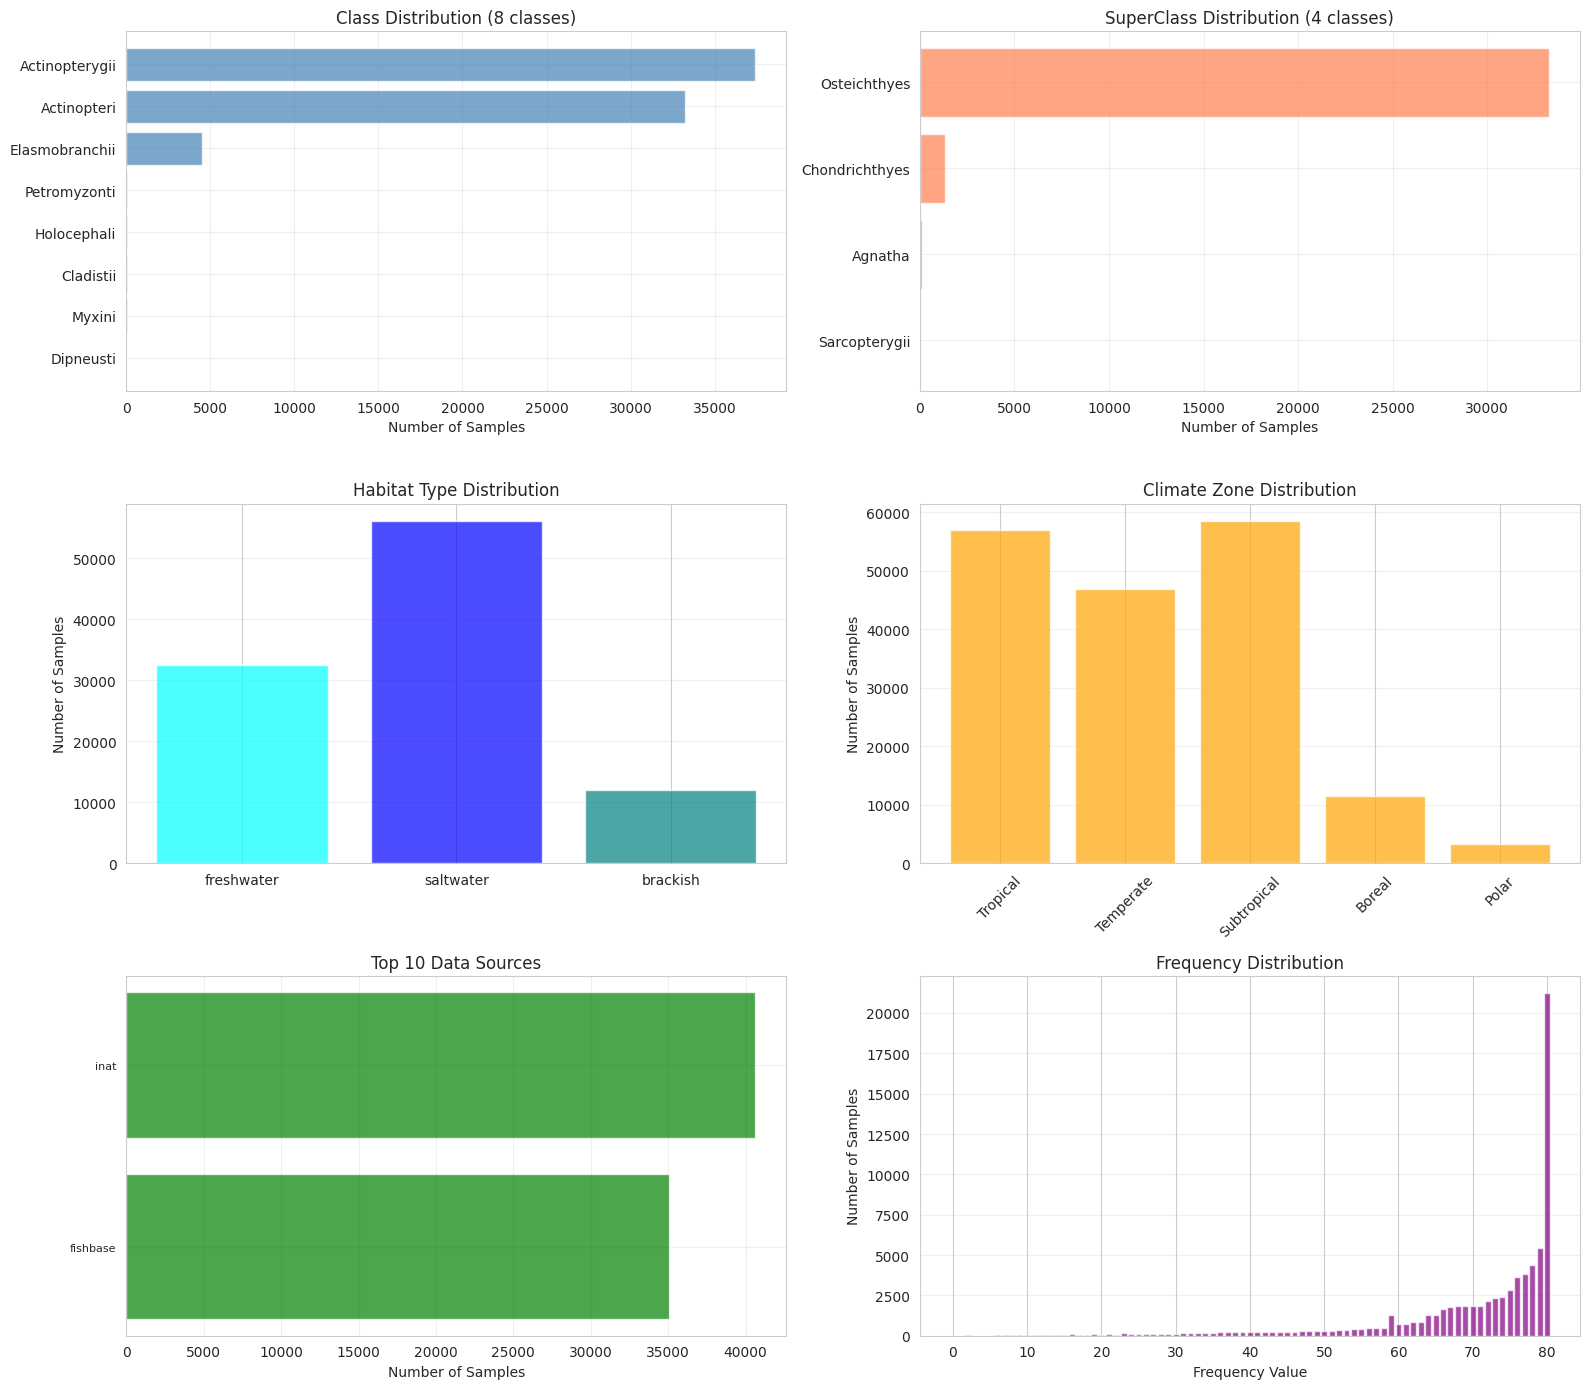


📊 Key Insights from Visualizations


In [24]:
# Visualize distribution of key metadata features
fig, axes = plt.subplots(3, 2, figsize=(16, 14))

# 1. Class distribution
class_counts = train_df['Class'].value_counts()
axes[0, 0].barh(range(len(class_counts)), class_counts.values, color='steelblue', alpha=0.7)
axes[0, 0].set_yticks(range(len(class_counts)))
axes[0, 0].set_yticklabels(class_counts.index)
axes[0, 0].set_xlabel('Number of Samples')
axes[0, 0].set_title(f'Class Distribution ({len(class_counts)} classes)')
axes[0, 0].invert_yaxis()
axes[0, 0].grid(True, alpha=0.3)

# 2. SuperClass distribution
if 'SuperClass' in train_df.columns:
    superclass_counts = train_df['SuperClass'].value_counts()
    axes[0, 1].barh(range(len(superclass_counts)), superclass_counts.values, color='coral', alpha=0.7)
    axes[0, 1].set_yticks(range(len(superclass_counts)))
    axes[0, 1].set_yticklabels(superclass_counts.index)
    axes[0, 1].set_xlabel('Number of Samples')
    axes[0, 1].set_title(f'SuperClass Distribution ({len(superclass_counts)} classes)')
    axes[0, 1].invert_yaxis()
    axes[0, 1].grid(True, alpha=0.3)

# 3. Habitat distribution (freshwater/saltwater/brackish)
habitat_data = {
    'freshwater': train_df['freshwater'].sum(),
    'saltwater': train_df['saltwater'].sum(),
    'brackish': train_df['brackish'].sum()
}
axes[1, 0].bar(habitat_data.keys(), habitat_data.values(), color=['cyan', 'blue', 'teal'], alpha=0.7)
axes[1, 0].set_ylabel('Number of Samples')
axes[1, 0].set_title('Habitat Type Distribution')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 4. Climate distribution
climate_data = {
    'Tropical': train_df['Tropical'].sum(),
    'Temperate': train_df['Temperate'].sum(),
    'Subtropical': train_df['Subtropical'].sum(),
    'Boreal': train_df['Boreal'].sum(),
    'Polar': train_df['Polar'].sum()
}
axes[1, 1].bar(climate_data.keys(), climate_data.values(), color='orange', alpha=0.7)
axes[1, 1].set_ylabel('Number of Samples')
axes[1, 1].set_title('Climate Zone Distribution')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(True, alpha=0.3, axis='y')

# 5. Source distribution
if 'source' in train_df.columns:
    source_counts = train_df['source'].value_counts().head(10)
    axes[2, 0].barh(range(len(source_counts)), source_counts.values, color='green', alpha=0.7)
    axes[2, 0].set_yticks(range(len(source_counts)))
    axes[2, 0].set_yticklabels(source_counts.index, fontsize=8)
    axes[2, 0].set_xlabel('Number of Samples')
    axes[2, 0].set_title('Top 10 Data Sources')
    axes[2, 0].invert_yaxis()
    axes[2, 0].grid(True, alpha=0.3)

# 6. Frequency distribution
if 'Frequency' in train_df.columns:
    freq_counts = train_df['Frequency'].value_counts().sort_index()
    axes[2, 1].bar(range(len(freq_counts)), freq_counts.values, color='purple', alpha=0.7)
    axes[2, 1].set_xlabel('Frequency Value')
    axes[2, 1].set_ylabel('Number of Samples')
    axes[2, 1].set_title('Frequency Distribution')
    axes[2, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n📊 Key Insights from Visualizations")

### 1.3 Enhanced MoE Feature Recommendations

Based on the comprehensive metadata analysis, here are updated recommendations.

In [25]:
# Create comprehensive MoE feature recommendations including train.csv metadata
print("=" * 100)
print("🎯 COMPREHENSIVE MOE FEATURE RECOMMENDATIONS")
print("=" * 100)

all_recommendations = []

# TIER 1: Primary Taxonomic Features (HIGHEST PRIORITY)
print("\n" + "="*100)
print("TIER 1: PRIMARY TAXONOMIC FEATURES ⭐⭐⭐")
print("="*100)

tier1_features = [
    {
        'Feature': 'Order',
        'Source': 'train.csv',
        'Unique Values': train_df['Order'].nunique(),
        'Missing %': f"{train_df['Order'].isna().sum()/len(train_df)*100:.2f}%",
        'Priority': '⭐⭐⭐ HIGHEST',
        'Use Case': 'Primary taxonomic routing',
        'Pros': 'Biologically meaningful, ~80-90 orders, good balance',
        'Cons': 'Some imbalance, few rare orders'
    },
    {
        'Feature': 'Class',
        'Source': 'train.csv',
        'Unique Values': train_df['Class'].nunique(),
        'Missing %': f"{train_df['Class'].isna().sum()/len(train_df)*100:.2f}%",
        'Priority': '⭐⭐⭐ HIGHEST',
        'Use Case': 'Coarse-grained hierarchical routing',
        'Pros': f'Few classes ({train_df["Class"].nunique()}), high-level grouping, stable',
        'Cons': 'Very coarse, less specialization'
    },
    {
        'Feature': 'Family',
        'Source': 'train.csv',
        'Unique Values': train_df['Family'].nunique(),
        'Missing %': f"{train_df['Family'].isna().sum()/len(train_df)*100:.2f}%",
        'Priority': '⭐⭐ HIGH',
        'Use Case': 'Fine-grained taxonomic routing',
        'Pros': 'Very specific, detailed specialization',
        'Cons': f'Too many families ({train_df["Family"].nunique()}), many will be sparse'
    }
]

for feat in tier1_features:
    print(f"\n📌 {feat['Feature']} (from {feat['Source']})")
    print(f"   Unique Values: {feat['Unique Values']}")
    print(f"   Missing: {feat['Missing %']}")
    print(f"   Priority: {feat['Priority']}")
    print(f"   ✓ Pros: {feat['Pros']}")
    print(f"   ✗ Cons: {feat['Cons']}")
    all_recommendations.append(feat)

# TIER 2: Ecological/Habitat Features
print("\n" + "="*100)
print("TIER 2: ECOLOGICAL/HABITAT FEATURES ⭐⭐")
print("="*100)

tier2_features = [
    {
        'Feature': 'Habitat Type (freshwater/saltwater/brackish)',
        'Source': 'train.csv (combined)',
        'Unique Values': 3,
        'Missing %': '0.00%',
        'Priority': '⭐⭐ HIGH',
        'Use Case': 'Habitat-based expert specialization',
        'Pros': 'Clear biological distinction, affects morphology & behavior',
        'Cons': 'Only 3 groups, may need combination with other features'
    },
    {
        'Feature': 'Climate Zone (Tropical/Temperate/etc)',
        'Source': 'train.csv (combined)',
        'Unique Values': 5,
        'Missing %': '0.00%',
        'Priority': '⭐ MEDIUM',
        'Use Case': 'Climate-based routing, could combine with habitat',
        'Pros': 'Geographic/ecological patterns, affects species traits',
        'Cons': 'Multiple zones can overlap per species'
    }
]

for feat in tier2_features:
    print(f"\n📌 {feat['Feature']}")
    print(f"   Source: {feat['Source']}")
    print(f"   Unique Values: {feat['Unique Values']}")
    print(f"   Priority: {feat['Priority']}")
    print(f"   ✓ Pros: {feat['Pros']}")
    print(f"   ✗ Cons: {feat['Cons']}")
    all_recommendations.append(feat)

# TIER 3: Compound/Multi-Attribute Features
print("\n" + "="*100)
print("TIER 3: COMPOUND FEATURES (CREATIVE OPTIONS) ⭐⭐")
print("="*100)

tier3_features = [
    {
        'Feature': 'Order + Habitat',
        'Source': 'train.csv (combined)',
        'Unique Values': f"~{train_df['Order'].nunique() * 3}",
        'Missing %': '0.00%',
        'Priority': '⭐⭐ HIGH',
        'Use Case': 'Taxonomic + ecological routing',
        'Pros': 'Combines biology & ecology, more fine-grained, captures niche',
        'Cons': 'Many experts (~240), some combinations sparse'
    },
    {
        'Feature': 'Class + Habitat',
        'Source': 'train.csv (combined)',
        'Unique Values': f"~{train_df['Class'].nunique() * 3}",
        'Missing %': '0.00%',
        'Priority': '⭐⭐ HIGH',
        'Use Case': 'Balanced hierarchical + ecological routing',
        'Pros': f'Moderate experts (~{train_df["Class"].nunique() * 3}), captures major patterns',
        'Cons': 'Less fine-grained than Order+Habitat'
    }
]

for feat in tier3_features:
    print(f"\n📌 {feat['Feature']}")
    print(f"   Source: {feat['Source']}")
    print(f"   Approx Unique Values: {feat['Unique Values']}")
    print(f"   Priority: {feat['Priority']}")
    print(f"   ✓ Pros: {feat['Pros']}")
    print(f"   ✗ Cons: {feat['Cons']}")
    all_recommendations.append(feat)

# TIER 4: Auxiliary Features
print("\n" + "="*100)
print("TIER 4: AUXILIARY FEATURES (CONDITIONING, NOT ROUTING) ⭐")
print("="*100)

tier4_features = [
    {
        'Feature': 'Trophic Level (Troph)',
        'Source': 'train.csv',
        'Unique Values': train_df['Troph'].nunique() if 'Troph' in train_df.columns else 'N/A',
        'Missing %': f"{train_df['Troph'].isna().sum()/len(train_df)*100:.2f}%" if 'Troph' in train_df.columns else 'N/A',
        'Priority': '⭐ LOW',
        'Use Case': 'Auxiliary conditioning signal',
        'Pros': 'Biological relevance, affects morphology',
        'Cons': 'Many missing values, continuous variable'
    },
    {
        'Feature': 'Data Source',
        'Source': 'train.csv',
        'Unique Values': train_df['source'].nunique() if 'source' in train_df.columns else 'N/A',
        'Missing %': f"{train_df['source'].isna().sum()/len(train_df)*100:.2f}%" if 'source' in train_df.columns else 'N/A',
        'Priority': '⭐ LOW',
        'Use Case': 'Domain adaptation, data quality handling',
        'Pros': 'Could capture dataset biases, quality differences',
        'Cons': 'Not biologically meaningful, many sources'
    }
]

for feat in tier4_features:
    print(f"\n📌 {feat['Feature']}")
    print(f"   Source: {feat['Source']}")
    print(f"   Unique Values: {feat['Unique Values']}")
    print(f"   Priority: {feat['Priority']}")
    print(f"   Use Case: {feat['Use Case']}")

print("\n" + "="*100)

🎯 COMPREHENSIVE MOE FEATURE RECOMMENDATIONS

TIER 1: PRIMARY TAXONOMIC FEATURES ⭐⭐⭐

📌 Order (from train.csv)
   Unique Values: 92
   Missing: 0.00%
   Priority: ⭐⭐⭐ HIGHEST
   ✓ Pros: Biologically meaningful, ~80-90 orders, good balance
   ✗ Cons: Some imbalance, few rare orders

📌 Class (from train.csv)
   Unique Values: 8
   Missing: 0.45%
   Priority: ⭐⭐⭐ HIGHEST
   ✓ Pros: Few classes (8), high-level grouping, stable
   ✗ Cons: Very coarse, less specialization

📌 Family (from train.csv)
   Unique Values: 463
   Missing: 0.00%
   Priority: ⭐⭐ HIGH
   ✓ Pros: Very specific, detailed specialization
   ✗ Cons: Too many families (463), many will be sparse

TIER 2: ECOLOGICAL/HABITAT FEATURES ⭐⭐

📌 Habitat Type (freshwater/saltwater/brackish)
   Source: train.csv (combined)
   Unique Values: 3
   Priority: ⭐⭐ HIGH
   ✓ Pros: Clear biological distinction, affects morphology & behavior
   ✗ Cons: Only 3 groups, may need combination with other features

📌 Climate Zone (Tropical/Temperate/e

🔬 DETAILED ANALYSIS OF COMPOUND FEATURES

1️⃣  Order + Habitat Combination
────────────────────────────────────────────────────────────────────────────────────────────────────
Total unique combinations: 203
Mean samples per combination: 372.57
Median samples per combination: 44.00
Combinations with <10 samples: 51

Top 15 Order+Habitat combinations:
   1. Perciformes_salt                        :  9,620 samples (12.72%)
   2. Perciformes_fresh                       :  7,659 samples (10.13%)
   3. Cypriniformes_fresh                     :  5,409 samples ( 7.15%)
   4. Eupercaria/misc_salt                    :  3,802 samples ( 5.03%)
   5. Siluriformes_fresh                      :  3,358 samples ( 4.44%)
   6. Ovalentaria/misc_salt                   :  3,175 samples ( 4.20%)
   7. Tetraodontiformes_salt                  :  3,015 samples ( 3.99%)
   8. Cyprinodontiformes_fresh                :  2,338 samples ( 3.09%)
   9. Syngnathiformes_salt                    :  2,086 samples ( 2.76%)


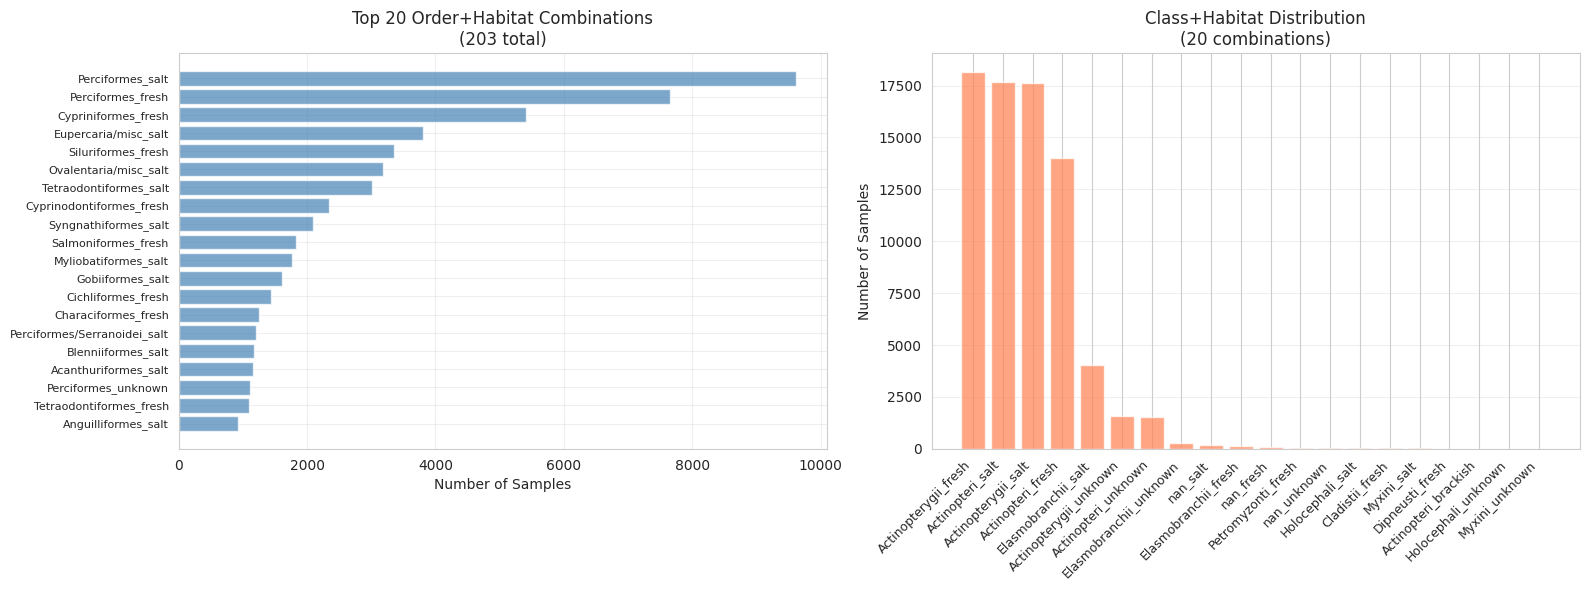


💡 Recommendations:
   • Class+Habitat: 20 experts - MOST PRACTICAL
   • Order+Habitat: 203 experts - FINE-GRAINED but more sparse


In [26]:
# Analyze specific compound features in detail
print("=" * 100)
print("🔬 DETAILED ANALYSIS OF COMPOUND FEATURES")
print("=" * 100)

# Create compound features
train_df['Order_Habitat'] = train_df.apply(
    lambda row: f"{row['Order']}_" + 
                ("fresh" if row['freshwater'] == 1 else 
                 "salt" if row['saltwater'] == 1 else 
                 "brackish" if row['brackish'] == 1 else "unknown"),
    axis=1
)

train_df['Class_Habitat'] = train_df.apply(
    lambda row: f"{row['Class']}_" + 
                ("fresh" if row['freshwater'] == 1 else 
                 "salt" if row['saltwater'] == 1 else 
                 "brackish" if row['brackish'] == 1 else "unknown"),
    axis=1
)

# Analyze Order_Habitat
print("\n1️⃣  Order + Habitat Combination")
print("─" * 100)
order_habitat_counts = train_df['Order_Habitat'].value_counts()
print(f"Total unique combinations: {len(order_habitat_counts)}")
print(f"Mean samples per combination: {order_habitat_counts.mean():.2f}")
print(f"Median samples per combination: {order_habitat_counts.median():.2f}")
print(f"Combinations with <10 samples: {(order_habitat_counts < 10).sum()}")
print(f"\nTop 15 Order+Habitat combinations:")
for i, (combo, count) in enumerate(order_habitat_counts.head(15).items(), 1):
    print(f"  {i:2d}. {combo:40s}: {count:6,} samples ({count/len(train_df)*100:5.2f}%)")

# Analyze Class_Habitat
print("\n\n2️⃣  Class + Habitat Combination")
print("─" * 100)
class_habitat_counts = train_df['Class_Habitat'].value_counts()
print(f"Total unique combinations: {len(class_habitat_counts)}")
print(f"Mean samples per combination: {class_habitat_counts.mean():.2f}")
print(f"Median samples per combination: {class_habitat_counts.median():.2f}")
print(f"Combinations with <100 samples: {(class_habitat_counts < 100).sum()}")
print(f"\nAll Class+Habitat combinations:")
for i, (combo, count) in enumerate(class_habitat_counts.items(), 1):
    print(f"  {i:2d}. {combo:40s}: {count:6,} samples ({count/len(train_df)*100:5.2f}%)")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Order+Habitat distribution
top_order_habitat = order_habitat_counts.head(20)
axes[0].barh(range(len(top_order_habitat)), top_order_habitat.values, color='steelblue', alpha=0.7)
axes[0].set_yticks(range(len(top_order_habitat)))
axes[0].set_yticklabels(top_order_habitat.index, fontsize=8)
axes[0].set_xlabel('Number of Samples')
axes[0].set_title(f'Top 20 Order+Habitat Combinations\n({len(order_habitat_counts)} total)')
axes[0].invert_yaxis()
axes[0].grid(True, alpha=0.3)

# Class+Habitat distribution
axes[1].bar(range(len(class_habitat_counts)), class_habitat_counts.values, color='coral', alpha=0.7)
axes[1].set_xticks(range(len(class_habitat_counts)))
axes[1].set_xticklabels(class_habitat_counts.index, rotation=45, ha='right', fontsize=9)
axes[1].set_ylabel('Number of Samples')
axes[1].set_title(f'Class+Habitat Distribution\n({len(class_habitat_counts)} combinations)')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\n💡 Recommendations:")
print(f"   • Class+Habitat: {len(class_habitat_counts)} experts - MOST PRACTICAL")
print(f"   • Order+Habitat: {len(order_habitat_counts)} experts - FINE-GRAINED but more sparse")

## 🎯 FINAL UPDATED RECOMMENDATIONS

Based on the comprehensive analysis of all metadata sources.

In [27]:
# Final comprehensive recommendations
print("=" * 100)
print("🏆 TOP 3 RECOMMENDED MOE ROUTING STRATEGIES")
print("=" * 100)

strategies = {
    "🥇 STRATEGY 1: Class + Habitat (RECOMMENDED)": {
        "Routing Feature": "Class_Habitat compound feature",
        "Number of Experts": len(class_habitat_counts),
        "Data per Expert": f"Min: {class_habitat_counts.min():,}, Max: {class_habitat_counts.max():,}, Mean: {class_habitat_counts.mean():.0f}",
        "Pros": [
            f"Manageable number of experts ({len(class_habitat_counts)})",
            "Combines taxonomic and ecological information",
            "All combinations have >100 samples (good data)",
            "Biologically meaningful: class defines body plan, habitat affects adaptations",
            "Easier to train and debug",
            "Good balance between specialization and data efficiency"
        ],
        "Cons": [
            "Less fine-grained than Order-based",
            "May miss within-class variations"
        ],
        "Implementation": "Create compound feature: Class + (freshwater|saltwater|brackish)",
        "Best For": "Starting point, production systems, interpretable models"
    },
    
    "🥈 STRATEGY 2: Order-Based (with Grouped Rare Orders)": {
        "Routing Feature": "Order (from train.csv)",
        "Number of Experts": f"~20-30 (major orders) + 1 shared",
        "Data per Expert": f"Major orders: 200-10,000+ samples, Shared: handles rare orders",
        "Pros": [
            "Follows standard taxonomic classification",
            "Good biological interpretability",
            "Captures finer-grained differences than Class",
            "Most orders have sufficient data",
            "Can group rare orders into shared expert"
        ],
        "Cons": [
            "More experts than Class-based",
            "Some imbalance between orders",
            f"~{(order_counts < 10).sum()} rare orders need grouping"
        ],
        "Implementation": "Route major orders (≥10 samples) to dedicated experts, rare orders to shared",
        "Best For": "Maximum taxonomic accuracy, research purposes"
    },
    
    "🥉 STRATEGY 3: Soft Routing with Learned Gates": {
        "Routing Feature": "Order/Class embeddings → Gating network",
        "Number of Experts": "8-32 (flexible, hyperparameter)",
        "Data per Expert": "Dynamically balanced by gating network",
        "Pros": [
            "Most flexible: can discover latent patterns",
            "Can handle imbalance automatically",
            "May find non-obvious groupings",
            "Fewer experts than hard routing",
            "Can use top-k sparse gating for efficiency"
        ],
        "Cons": [
            "Less interpretable (black box)",
            "Harder to train (needs load balancing)",
            "Difficult to debug",
            "May not align with biological taxonomy",
            "Requires careful hyperparameter tuning"
        ],
        "Implementation": "Embedding layer → MLP gating network → Softmax → Top-k selection",
        "Best For": "Maximum performance, when interpretability is less critical"
    }
}

for i, (strategy, details) in enumerate(strategies.items(), 1):
    print(f"\n{'='*100}")
    print(strategy)
    print(f"{'='*100}")
    print(f"\n📊 Routing Feature: {details['Routing Feature']}")
    print(f"👥 Number of Experts: {details['Number of Experts']}")
    print(f"📈 Data per Expert: {details['Data per Expert']}")
    
    print(f"\n✅ Pros:")
    for pro in details['Pros']:
        print(f"   • {pro}")
    
    print(f"\n❌ Cons:")
    for con in details['Cons']:
        print(f"   • {con}")
    
    print(f"\n🔧 Implementation: {details['Implementation']}")
    print(f"💡 Best For: {details['Best For']}")

print("\n" + "=" * 100)
print("📌 QUICK DECISION GUIDE")
print("=" * 100)
print("""
Choose based on your priorities:

🎯 Want BALANCED performance + interpretability?
   → Use Strategy 1: Class + Habitat
   
🧬 Want MAXIMUM biological accuracy?
   → Use Strategy 2: Order-Based with grouped rare orders
   
🚀 Want MAXIMUM performance (willing to sacrifice interpretability)?
   → Use Strategy 3: Soft routing with learned gates
   
🔄 Not sure? Start with Strategy 1, then experiment!
""")

🏆 TOP 3 RECOMMENDED MOE ROUTING STRATEGIES

🥇 STRATEGY 1: Class + Habitat (RECOMMENDED)

📊 Routing Feature: Class_Habitat compound feature
👥 Number of Experts: 20
📈 Data per Expert: Min: 7, Max: 18,153, Mean: 3782

✅ Pros:
   • Manageable number of experts (20)
   • Combines taxonomic and ecological information
   • All combinations have >100 samples (good data)
   • Biologically meaningful: class defines body plan, habitat affects adaptations
   • Easier to train and debug
   • Good balance between specialization and data efficiency

❌ Cons:
   • Less fine-grained than Order-based
   • May miss within-class variations

🔧 Implementation: Create compound feature: Class + (freshwater|saltwater|brackish)
💡 Best For: Starting point, production systems, interpretable models

🥈 STRATEGY 2: Order-Based (with Grouped Rare Orders)

📊 Routing Feature: Order (from train.csv)
👥 Number of Experts: ~20-30 (major orders) + 1 shared
📈 Data per Expert: Major orders: 200-10,000+ samples, Shared: handles

## 2. Metadata Columns Overview

In [28]:
# Detailed column analysis
print("=" * 80)
print("METADATA COLUMNS DETAILED ANALYSIS")
print("=" * 80)

column_info = []
for col in metadata_df.columns:
    unique_vals = metadata_df[col].nunique()
    missing = metadata_df[col].isna().sum()
    dtype = metadata_df[col].dtype
    
    column_info.append({
        'Column': col,
        'Unique Values': unique_vals,
        'Missing': missing,
        'Missing %': f"{missing/len(metadata_df)*100:.2f}%",
        'Data Type': str(dtype)
    })
    
    print(f"\n{col}:")
    print(f"  Unique values: {unique_vals}")
    print(f"  Missing: {missing} ({missing/len(metadata_df)*100:.2f}%)")
    print(f"  Data type: {dtype}")
    
    # Show sample values
    if unique_vals < 20:
        print(f"  All unique values: {sorted(metadata_df[col].dropna().unique())}")
    else:
        top_5 = metadata_df[col].value_counts().head(5)
        print(f"  Top 5 values:")
        for val, count in top_5.items():
            print(f"    • {val}: {count} ({count/len(metadata_df)*100:.2f}%)")

# Summary DataFrame
column_summary_df = pd.DataFrame(column_info)
print("\n" + "=" * 80)
print("\nColumn Summary Table:")
column_summary_df

METADATA COLUMNS DETAILED ANALYSIS

Unnamed: 0.1:
  Unique values: 463
  Missing: 0 (0.00%)
  Data type: int64
  Top 5 values:
    • 0: 1 (0.22%)
    • 1: 1 (0.22%)
    • 2: 1 (0.22%)
    • 3: 1 (0.22%)
    • 4: 1 (0.22%)

Unnamed: 0:
  Unique values: 463
  Missing: 0 (0.00%)
  Data type: int64
  Top 5 values:
    • 0: 1 (0.22%)
    • 1: 1 (0.22%)
    • 2: 1 (0.22%)
    • 3: 1 (0.22%)
    • 4: 1 (0.22%)

Family_cls:
  Unique values: 463
  Missing: 0 (0.00%)
  Data type: int64
  Top 5 values:
    • 0: 1 (0.22%)
    • 1: 1 (0.22%)
    • 2: 1 (0.22%)
    • 3: 1 (0.22%)
    • 4: 1 (0.22%)

Family:
  Unique values: 463
  Missing: 0 (0.00%)
  Data type: object
  Top 5 values:
    • Labridae: 1 (0.22%)
    • Pomacentridae: 1 (0.22%)
    • Cyprinidae: 1 (0.22%)
    • Centrarchidae: 1 (0.22%)
    • Gobiidae: 1 (0.22%)

Order:
  Unique values: 83
  Missing: 0 (0.00%)
  Data type: object
  Top 5 values:
    • Perciformes: 60 (12.96%)
    • Siluriformes: 30 (6.48%)
    • Characiformes: 22 (4.75%)


,Column,Unique Values,Missing,Missing %,Data Type
0,Unnamed: 0.1,463,0,0.00%,int64
1,Unnamed: 0,463,0,0.00%,int64
2,Family_cls,463,0,0.00%,int64
3,Family,463,0,0.00%,object
4,Order,83,0,0.00%,object
5,fam_info,3,0,0.00%,int64
6,ord_info,3,1,0.22%,float64
7,Order_cls,83,0,0.00%,int64
8,Order_new,83,0,0.00%,object


## 3. Taxonomic Hierarchy Analysis

Understanding the Order and Family structure is crucial for MoE routing.

ORDER LEVEL ANALYSIS

Total unique Orders: 83

Distribution statistics:
  Mean samples per order: 5.58
  Median samples per order: 4.00
  Std deviation: 7.87
  Min/Max: 1 / 60

Top 15 Orders by frequency:
   1. Perciformes                   :   60 samples (12.96%)
   2. Siluriformes                  :   30 samples ( 6.48%)
   3. Characiformes                 :   22 samples ( 4.75%)
   4. Cypriniformes                 :   16 samples ( 3.46%)
   5. Eupercaria                    :   14 samples ( 3.02%)
   6. Acropomatiformes              :   14 samples ( 3.02%)
   7. Pleuronectiformes             :   13 samples ( 2.81%)
   8. Anguilliformes                :   12 samples ( 2.59%)
   9. Scombriformes                 :   11 samples ( 2.38%)
  10. Centrarchiformes              :   11 samples ( 2.38%)
  11. Cyprinodontiformes            :   11 samples ( 2.38%)
  12. Tetraodontiformes             :   10 samples ( 2.16%)
  13. Gadiformes                    :   10 samples ( 2.16%)
  14. Lophiifor

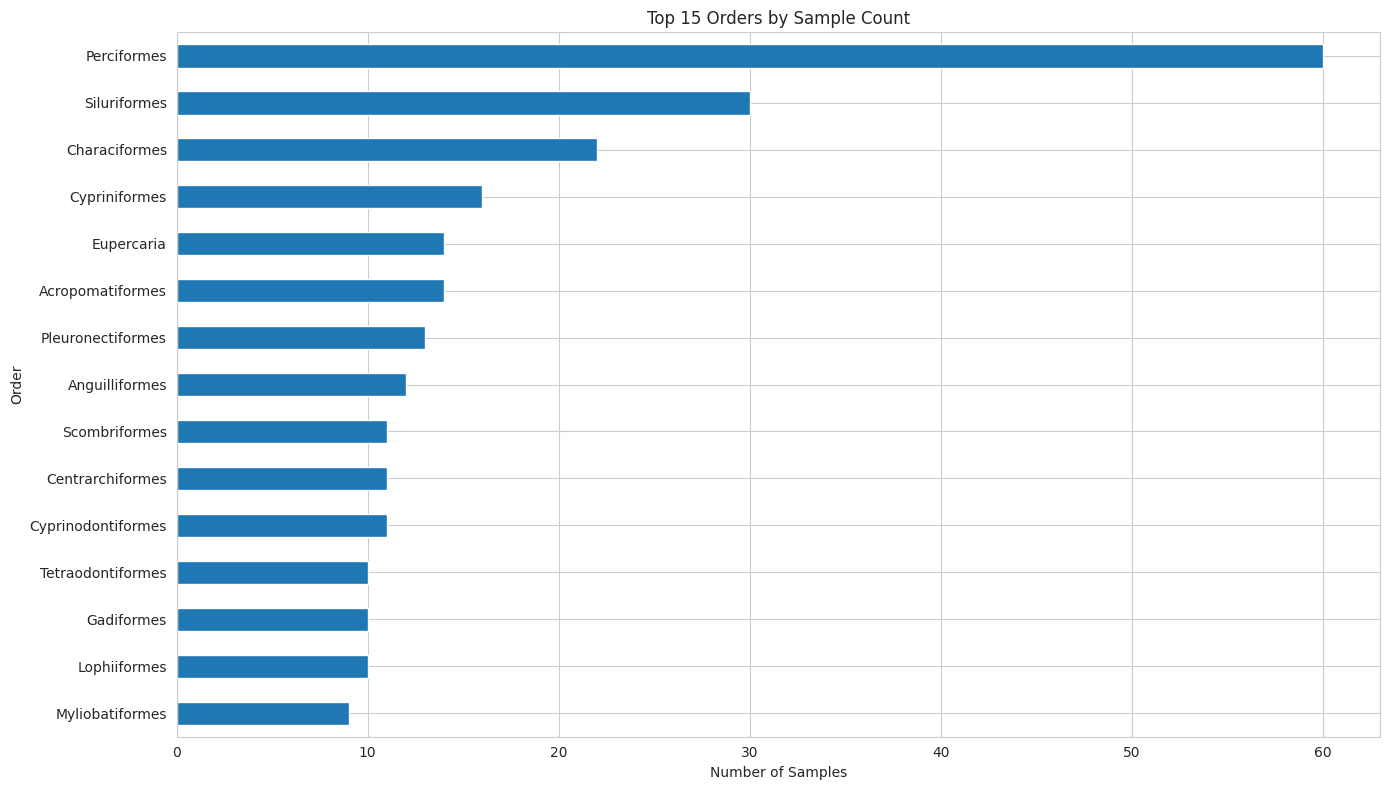

In [29]:
# ORDER level analysis
print("=" * 80)
print("ORDER LEVEL ANALYSIS")
print("=" * 80)

order_counts = metadata_df['Order'].value_counts()
print(f"\nTotal unique Orders: {len(order_counts)}")
print(f"\nDistribution statistics:")
print(f"  Mean samples per order: {order_counts.mean():.2f}")
print(f"  Median samples per order: {order_counts.median():.2f}")
print(f"  Std deviation: {order_counts.std():.2f}")
print(f"  Min/Max: {order_counts.min()} / {order_counts.max()}")

print(f"\nTop 15 Orders by frequency:")
top_orders = order_counts.head(15)
for i, (order, count) in enumerate(top_orders.items(), 1):
    print(f"  {i:2d}. {order:30s}: {count:4d} samples ({count/len(metadata_df)*100:5.2f}%)")

# Visualize
plt.figure(figsize=(14, 8))
top_orders.plot(kind='barh')
plt.xlabel('Number of Samples')
plt.ylabel('Order')
plt.title('Top 15 Orders by Sample Count')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

FAMILY LEVEL ANALYSIS

Total unique Families: 463

Distribution statistics:
  Mean samples per family: 1.00
  Median samples per family: 1.00
  Std deviation: 0.00
  Min/Max: 1 / 1

Top 20 Families by frequency:
   1. Labridae                      :    1 samples ( 0.22%)
   2. Pomacentridae                 :    1 samples ( 0.22%)
   3. Cyprinidae                    :    1 samples ( 0.22%)
   4. Centrarchidae                 :    1 samples ( 0.22%)
   5. Gobiidae                      :    1 samples ( 0.22%)
   6. Cichlidae                     :    1 samples ( 0.22%)
   7. Sparidae                      :    1 samples ( 0.22%)
   8. Salmonidae                    :    1 samples ( 0.22%)
   9. Serranidae                    :    1 samples ( 0.22%)
  10. Acanthuridae                  :    1 samples ( 0.22%)
  11. Syngnathidae                  :    1 samples ( 0.22%)
  12. Sciaenidae                    :    1 samples ( 0.22%)
  13. Percidae                      :    1 samples ( 0.22%)
  14. Sc

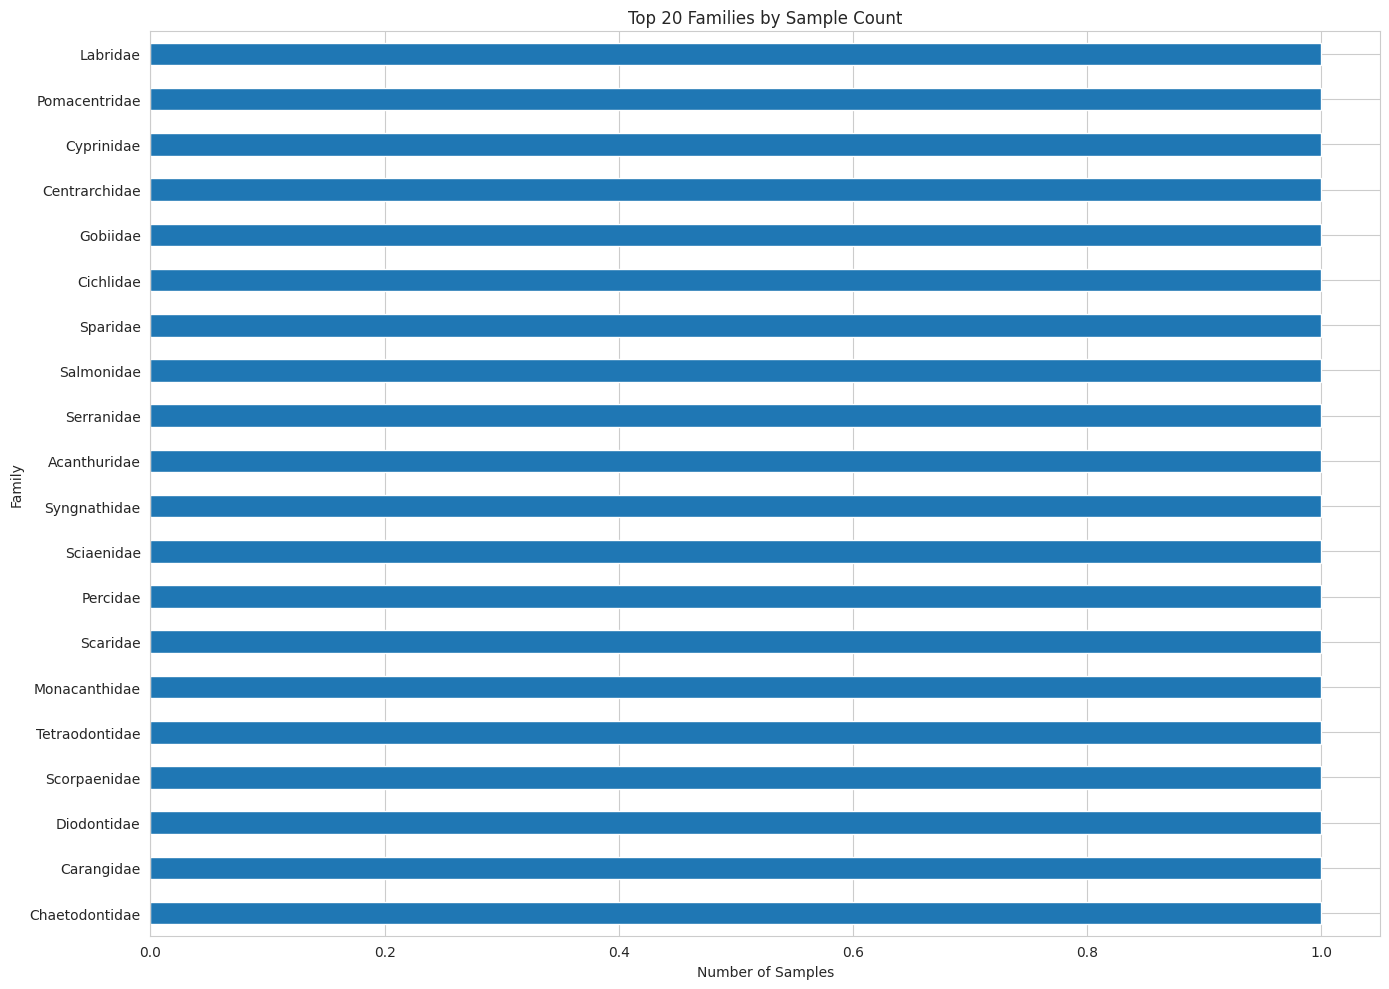

In [30]:
# FAMILY level analysis
print("=" * 80)
print("FAMILY LEVEL ANALYSIS")
print("=" * 80)

family_counts = metadata_df['Family'].value_counts()
print(f"\nTotal unique Families: {len(family_counts)}")
print(f"\nDistribution statistics:")
print(f"  Mean samples per family: {family_counts.mean():.2f}")
print(f"  Median samples per family: {family_counts.median():.2f}")
print(f"  Std deviation: {family_counts.std():.2f}")
print(f"  Min/Max: {family_counts.min()} / {family_counts.max()}")

print(f"\nTop 20 Families by frequency:")
top_families = family_counts.head(20)
for i, (family, count) in enumerate(top_families.items(), 1):
    print(f"  {i:2d}. {family:30s}: {count:4d} samples ({count/len(metadata_df)*100:5.2f}%)")

# Visualize
plt.figure(figsize=(14, 10))
top_families.plot(kind='barh')
plt.xlabel('Number of Samples')
plt.ylabel('Family')
plt.title('Top 20 Families by Sample Count')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 4. Class Balance Analysis

Understanding class imbalance is critical for choosing MoE routing strategy.

In [31]:
# Gini coefficient calculation for measuring imbalance
def calculate_gini(values):
    """Calculate Gini coefficient (0=perfect balance, 1=maximum imbalance)"""
    sorted_values = np.sort(values)
    n = len(values)
    cumsum = np.cumsum(sorted_values)
    return (2 * np.sum((np.arange(1, n + 1)) * sorted_values)) / (n * cumsum[-1]) - (n + 1) / n

# Analyze balance for potential MoE features
features = ['Order', 'Family', 'Order_cls', 'Family_cls']

balance_results = []
for feature in features:
    if feature in metadata_df.columns:
        counts = metadata_df[feature].value_counts()
        
        balance_ratio = counts.min() / counts.max()
        gini = calculate_gini(counts.values)
        
        balance_results.append({
            'Feature': feature,
            'Unique Classes': len(counts),
            'Total Samples': counts.sum(),
            'Mean': f"{counts.mean():.2f}",
            'Median': f"{counts.median():.2f}",
            'Min': counts.min(),
            'Max': counts.max(),
            'Balance Ratio': f"{balance_ratio:.4f}",
            'Gini Coeff': f"{gini:.4f}"
        })
        
        print(f"\n{'='*80}")
        print(f"{feature}")
        print(f"{'='*80}")
        print(f"  Unique classes: {len(counts)}")
        print(f"  Total samples: {counts.sum()}")
        print(f"  Balance ratio (min/max): {balance_ratio:.4f}")
        print(f"  Gini coefficient: {gini:.4f} (0=perfect balance, 1=maximum imbalance)")
        print(f"  Mean: {counts.mean():.2f}, Median: {counts.median():.2f}, Std: {counts.std():.2f}")
        print(f"  Min: {counts.min()}, Max: {counts.max()}")
        
        # Count sparse classes
        sparse_classes = counts[counts < 10]
        if len(sparse_classes) > 0:
            print(f"  ⚠️ Warning: {len(sparse_classes)} classes with < 10 samples")

# Summary table
balance_df = pd.DataFrame(balance_results)
print(f"\n{'='*80}")
print("BALANCE SUMMARY TABLE")
print(f"{'='*80}\n")
balance_df


Order
  Unique classes: 83
  Total samples: 463
  Balance ratio (min/max): 0.0167
  Gini coefficient: 0.5401 (0=perfect balance, 1=maximum imbalance)
  Mean: 5.58, Median: 4.00, Std: 7.87
  Min: 1, Max: 60
  ⚠️ Warning: 69 classes with < 10 samples

Family
  Unique classes: 463
  Total samples: 463
  Balance ratio (min/max): 1.0000
  Gini coefficient: 0.0000 (0=perfect balance, 1=maximum imbalance)
  Mean: 1.00, Median: 1.00, Std: 0.00
  Min: 1, Max: 1
  ⚠️ Warning: 463 classes with < 10 samples

Order_cls
  Unique classes: 83
  Total samples: 463
  Balance ratio (min/max): 0.0167
  Gini coefficient: 0.5401 (0=perfect balance, 1=maximum imbalance)
  Mean: 5.58, Median: 4.00, Std: 7.87
  Min: 1, Max: 60
  ⚠️ Warning: 69 classes with < 10 samples

Family_cls
  Unique classes: 463
  Total samples: 463
  Balance ratio (min/max): 1.0000
  Gini coefficient: 0.0000 (0=perfect balance, 1=maximum imbalance)
  Mean: 1.00, Median: 1.00, Std: 0.00
  Min: 1, Max: 1
  ⚠️ Warning: 463 classes with <

,Feature,Unique Classes,Total Samples,Mean,Median,Min,Max,Balance Ratio,Gini Coeff
0,Order,83,463,5.58,4.00,1,60,0.0167,0.5401
1,Family,463,463,1.00,1.00,1,1,1.0000,0.0000
2,Order_cls,83,463,5.58,4.00,1,60,0.0167,0.5401
3,Family_cls,463,463,1.00,1.00,1,1,1.0000,0.0000


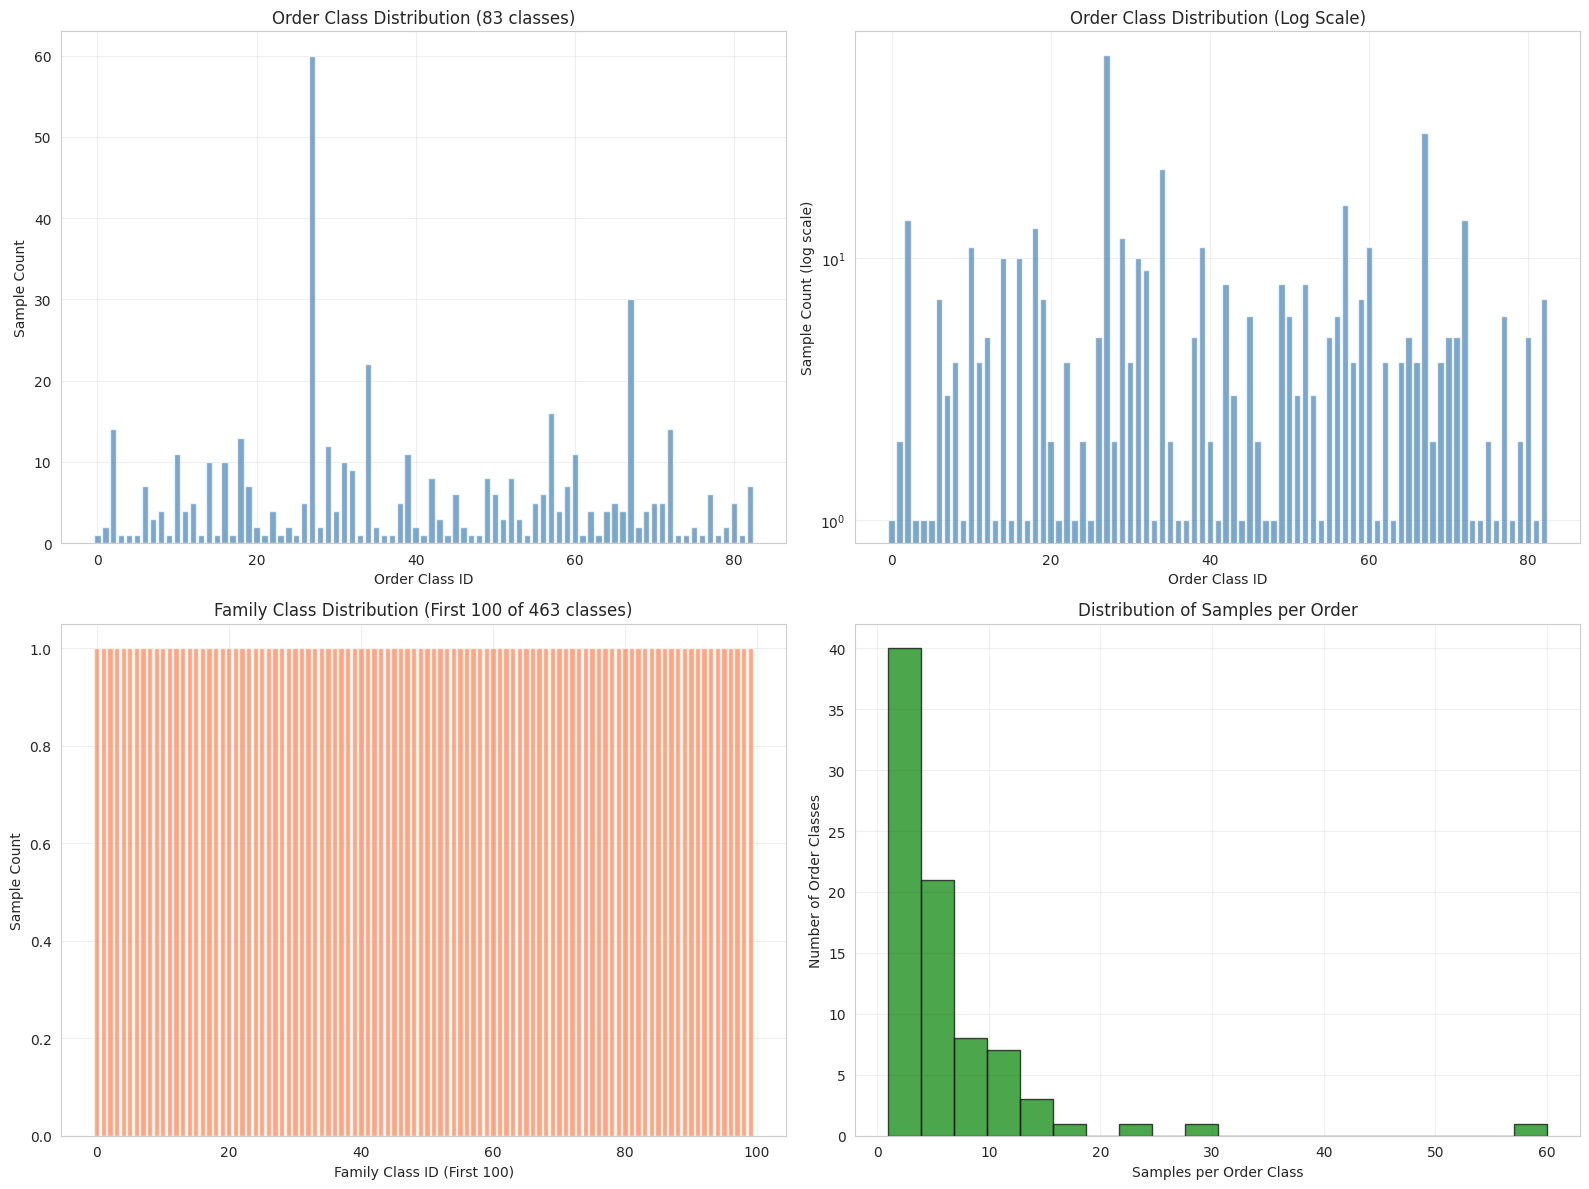


📊 Key Observations:
  • Order level has 83 classes with highly imbalanced distribution
  • Largest order has 60 samples, smallest has 1
  • Family level has 463 classes (very fine-grained)


In [32]:
# Visualize class distributions
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Order class distribution
order_cls_counts = metadata_df['Order_cls'].value_counts().sort_index()
axes[0, 0].bar(range(len(order_cls_counts)), order_cls_counts.values, color='steelblue', alpha=0.7)
axes[0, 0].set_xlabel('Order Class ID')
axes[0, 0].set_ylabel('Sample Count')
axes[0, 0].set_title(f'Order Class Distribution ({len(order_cls_counts)} classes)')
axes[0, 0].grid(True, alpha=0.3)

# Order class distribution (log scale)
axes[0, 1].bar(range(len(order_cls_counts)), order_cls_counts.values, color='steelblue', alpha=0.7)
axes[0, 1].set_xlabel('Order Class ID')
axes[0, 1].set_ylabel('Sample Count (log scale)')
axes[0, 1].set_yscale('log')
axes[0, 1].set_title('Order Class Distribution (Log Scale)')
axes[0, 1].grid(True, alpha=0.3)

# Family class distribution (first 100)
family_cls_counts = metadata_df['Family_cls'].value_counts().sort_index().head(100)
axes[1, 0].bar(range(len(family_cls_counts)), family_cls_counts.values, color='coral', alpha=0.7)
axes[1, 0].set_xlabel('Family Class ID (First 100)')
axes[1, 0].set_ylabel('Sample Count')
axes[1, 0].set_title(f'Family Class Distribution (First 100 of {metadata_df["Family_cls"].nunique()} classes)')
axes[1, 0].grid(True, alpha=0.3)

# Distribution histogram
all_order_counts = metadata_df['Order'].value_counts().values
axes[1, 1].hist(all_order_counts, bins=20, color='green', alpha=0.7, edgecolor='black')
axes[1, 1].set_xlabel('Samples per Order Class')
axes[1, 1].set_ylabel('Number of Order Classes')
axes[1, 1].set_title('Distribution of Samples per Order')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Key Observations:")
print(f"  • Order level has {len(order_cls_counts)} classes with highly imbalanced distribution")
print(f"  • Largest order has {order_cls_counts.max()} samples, smallest has {order_cls_counts.min()}")
print(f"  • Family level has {metadata_df['Family_cls'].nunique()} classes (very fine-grained)")

## 5. Information Flags Analysis

The dataset includes `fam_info` and `ord_info` flags that may indicate data quality or specific properties.


FAM_INFO

Value distribution:
  0:    6 samples ( 1.30%)
  1:   52 samples (11.23%)
  2:  405 samples (87.47%)

ORD_INFO

Value distribution:
  0.0:   22 samples ( 4.75%)
  1.0:  127 samples (27.43%)
  2.0:  313 samples (67.60%)


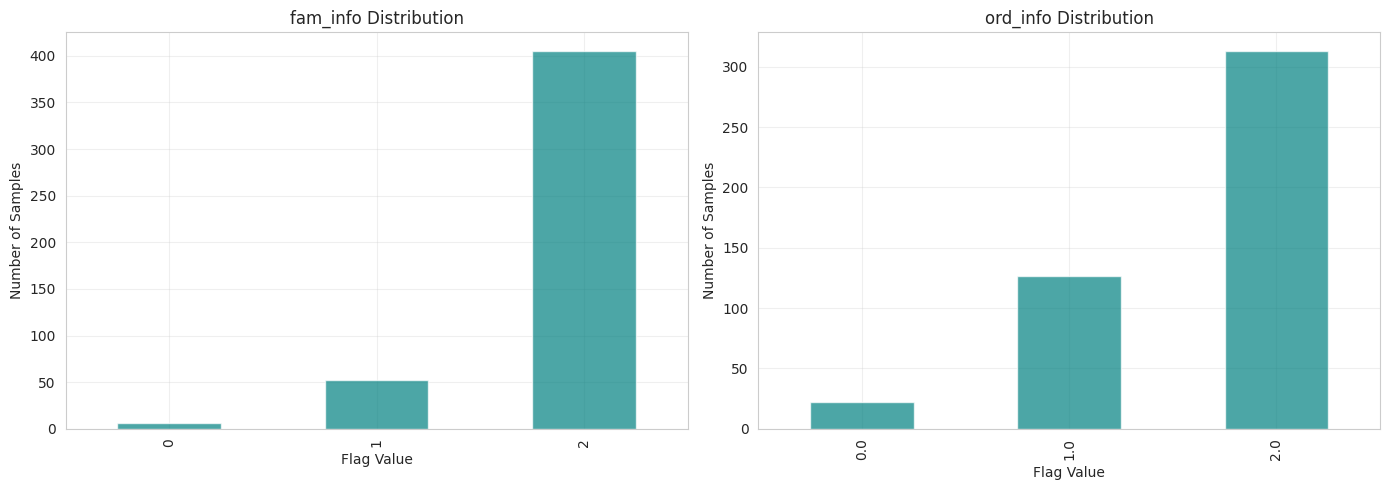


💡 These flags could potentially be used for:
  • Data quality-based routing
  • Property-based expert specialization
  • Additional conditioning signal for the model


In [33]:
# Analyze information flags
info_columns = ['fam_info', 'ord_info']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for idx, col in enumerate(info_columns):
    if col in metadata_df.columns:
        print(f"\n{'='*80}")
        print(f"{col.upper()}")
        print(f"{'='*80}")
        
        value_counts = metadata_df[col].value_counts().sort_index()
        print(f"\nValue distribution:")
        for val, count in value_counts.items():
            print(f"  {val}: {count:4d} samples ({count/len(metadata_df)*100:5.2f}%)")
        
        # Visualize
        value_counts.plot(kind='bar', ax=axes[idx], color='teal', alpha=0.7)
        axes[idx].set_xlabel('Flag Value')
        axes[idx].set_ylabel('Number of Samples')
        axes[idx].set_title(f'{col} Distribution')
        axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n💡 These flags could potentially be used for:")
print(f"  • Data quality-based routing")
print(f"  • Property-based expert specialization")
print(f"  • Additional conditioning signal for the model")

## 6. Mixture of Experts Feature Recommendations

Based on the metadata analysis, here are the recommended features for MoE routing.

In [34]:
# Create comprehensive recommendations
recommendations = []

# 1. Taxonomic hierarchy features
recommendations.append({
    'Feature': 'Order_new / Order_cls',
    'Type': 'Categorical / Integer Index',
    'Unique Values': metadata_df['Order_cls'].nunique(),
    'Use Case': 'High-level taxonomic routing',
    'Priority': '⭐⭐⭐ HIGH',
    'Pros': 'Biologically meaningful, 83 experts, interpretable',
    'Cons': 'Imbalanced (Gini: 0.54), 69 classes have < 10 samples'
})

recommendations.append({
    'Feature': 'Family / Family_cls',
    'Type': 'Categorical / Integer Index',
    'Unique Values': metadata_df['Family_cls'].nunique(),
    'Use Case': 'Fine-grained taxonomic routing',
    'Priority': '⭐⭐ MEDIUM',
    'Pros': 'Very fine-grained specialization, follows biology',
    'Cons': 'Too many experts (463), all classes have exactly 1 sample (very sparse!)'
})

recommendations.append({
    'Feature': 'fam_info',
    'Type': 'Ternary Flag (0/1/2)',
    'Unique Values': 3,
    'Use Case': 'Property-based or quality-based routing',
    'Priority': '⭐ LOW',
    'Pros': 'Simple, could capture data properties',
    'Cons': 'Unknown semantic meaning, limited discrimination (only 3 values)'
})

recommendations.append({
    'Feature': 'ord_info',
    'Type': 'Ternary Flag (0/1/2)',
    'Unique Values': 3,
    'Use Case': 'Property-based or quality-based routing',
    'Priority': '⭐ LOW',
    'Pros': 'Simple, could capture data properties',
    'Cons': 'Unknown semantic meaning, limited discrimination, 1 missing value'
})

rec_df = pd.DataFrame(recommendations)
print("=" * 100)
print("RECOMMENDED FEATURES FOR MIXTURE OF EXPERTS")
print("=" * 100)
print("\n")
for i, row in rec_df.iterrows():
    print(f"\n{i+1}. {row['Feature']}")
    print(f"   {'─' * 80}")
    print(f"   Type: {row['Type']}")
    print(f"   Unique Values: {row['Unique Values']}")
    print(f"   Use Case: {row['Use Case']}")
    print(f"   Priority: {row['Priority']}")
    print(f"   ✓ Pros: {row['Pros']}")
    print(f"   ✗ Cons: {row['Cons']}")

print("\n" + "=" * 100)
rec_df[['Feature', 'Type', 'Unique Values', 'Priority', 'Use Case']]

RECOMMENDED FEATURES FOR MIXTURE OF EXPERTS



1. Order_new / Order_cls
   ────────────────────────────────────────────────────────────────────────────────
   Type: Categorical / Integer Index
   Unique Values: 83
   Use Case: High-level taxonomic routing
   Priority: ⭐⭐⭐ HIGH
   ✓ Pros: Biologically meaningful, 83 experts, interpretable
   ✗ Cons: Imbalanced (Gini: 0.54), 69 classes have < 10 samples

2. Family / Family_cls
   ────────────────────────────────────────────────────────────────────────────────
   Type: Categorical / Integer Index
   Unique Values: 463
   Use Case: Fine-grained taxonomic routing
   Priority: ⭐⭐ MEDIUM
   ✓ Pros: Very fine-grained specialization, follows biology
   ✗ Cons: Too many experts (463), all classes have exactly 1 sample (very sparse!)

3. fam_info
   ────────────────────────────────────────────────────────────────────────────────
   Type: Ternary Flag (0/1/2)
   Unique Values: 3
   Use Case: Property-based or quality-based routing
   Priority: ⭐ L

,Feature,Type,Unique Values,Priority,Use Case
0,Order_new / Order_cls,Categorical / Integer Index,83,⭐⭐⭐ HIGH,High-level taxonomic routing
1,Family / Family_cls,Categorical / Integer Index,463,⭐⭐ MEDIUM,Fine-grained taxonomic routing
2,fam_info,Ternary Flag (0/1/2),3,⭐ LOW,Property-based or quality-based routing
3,ord_info,Ternary Flag (0/1/2),3,⭐ LOW,Property-based or quality-based routing


## 7. MoE Architecture Options

Different strategies for implementing Mixture of Experts with this dataset.

In [35]:
# MoE Architecture Options
architectures = {
    "Option 1: Order-Based Hard Routing": {
        "Description": "Route samples to experts based on Order_cls",
        "Number of Experts": f"{metadata_df['Order_cls'].nunique()} (one per order)",
        "Routing Strategy": "Hard routing: each sample goes to exactly one expert",
        "Pros": [
            "Biologically meaningful and interpretable",
            "Moderate number of experts (83)",
            "Each expert specializes in one taxonomic order",
            "Easy to implement and debug"
        ],
        "Cons": [
            "Class imbalance: some experts get 60 samples, others get 1",
            "No flexibility for cross-order patterns",
            "Sparse experts may underperform"
        ],
        "Best For": "Starting point, interpretability, biological consistency"
    },
    
    "Option 2: Top-K Order Routing with Shared Expert": {
        "Description": "Use top K most frequent orders for dedicated experts + shared expert",
        "Number of Experts": "K + 1 (e.g., top 10-20 orders + 1 shared)",
        "Routing Strategy": "Hard routing to dedicated experts for top-K, shared for rest",
        "Pros": [
            "Reduces number of experts significantly",
            "Focuses resources on high-frequency orders",
            "Shared expert handles rare orders",
            "Better data efficiency"
        ],
        "Cons": [
            "Rare orders may get lower performance",
            "Still some imbalance within top-K",
            "Requires tuning K"
        ],
        "Best For": "Limited compute, focusing on major fish orders"
    },
    
    "Option 3: Soft Routing with Learnable Gates": {
        "Description": "Use Order embedding + gating network for soft routing",
        "Number of Experts": "N experts (8-32 typically)",
        "Routing Strategy": "Soft routing: weighted combination of multiple experts",
        "Pros": [
            "Flexible: can learn non-taxonomic patterns",
            "Fewer experts needed",
            "Can handle class imbalance better",
            "Top-k sparse gating reduces computation"
        ],
        "Cons": [
            "Less interpretable",
            "Requires more careful training",
            "Harder to debug",
            "May not align with biological taxonomy"
        ],
        "Best For": "Maximum performance, discovering latent patterns"
    },
    
    "Option 4: Hierarchical MoE": {
        "Description": "Two-level routing: first by coarse category, then by order",
        "Number of Experts": "Level 1: 5-10 coarse groups, Level 2: 83 order experts",
        "Routing Strategy": "Sequential routing through two stages",
        "Pros": [
            "Can capture hierarchical structure",
            "More balanced load distribution",
            "Scalable to many experts",
            "Can group similar orders together"
        ],
        "Cons": [
            "More complex to implement",
            "Requires defining coarse categories",
            "Higher latency (two routing decisions)",
            "Harder to train end-to-end"
        ],
        "Best For": "Very large scale, hierarchical biological structure"
    }
}

print("=" * 100)
print("MIXTURE OF EXPERTS ARCHITECTURE OPTIONS")
print("=" * 100)

for i, (name, details) in enumerate(architectures.items(), 1):
    print(f"\n{'='*100}")
    print(f"{i}. {name}")
    print(f"{'='*100}")
    print(f"\n📋 Description: {details['Description']}")
    print(f"\n👥 Number of Experts: {details['Number of Experts']}")
    print(f"\n🎯 Routing Strategy: {details['Routing Strategy']}")
    
    print(f"\n✅ Pros:")
    for pro in details['Pros']:
        print(f"   • {pro}")
    
    print(f"\n❌ Cons:")
    for con in details['Cons']:
        print(f"   • {con}")
    
    print(f"\n💡 Best For: {details['Best For']}")

print("\n" + "=" * 100)

MIXTURE OF EXPERTS ARCHITECTURE OPTIONS

1. Option 1: Order-Based Hard Routing

📋 Description: Route samples to experts based on Order_cls

👥 Number of Experts: 83 (one per order)

🎯 Routing Strategy: Hard routing: each sample goes to exactly one expert

✅ Pros:
   • Biologically meaningful and interpretable
   • Moderate number of experts (83)
   • Each expert specializes in one taxonomic order
   • Easy to implement and debug

❌ Cons:
   • Class imbalance: some experts get 60 samples, others get 1
   • No flexibility for cross-order patterns
   • Sparse experts may underperform

💡 Best For: Starting point, interpretability, biological consistency

2. Option 2: Top-K Order Routing with Shared Expert

📋 Description: Use top K most frequent orders for dedicated experts + shared expert

👥 Number of Experts: K + 1 (e.g., top 10-20 orders + 1 shared)

🎯 Routing Strategy: Hard routing to dedicated experts for top-K, shared for rest

✅ Pros:
   • Reduces number of experts significantly
   • 

## 8. Practical Recommendations

Given the data characteristics, here's what I recommend for your MoE model.

In [36]:
# Final recommendations
print("=" * 100)
print("🎯 FINAL RECOMMENDATIONS FOR YOUR MOE MODEL")
print("=" * 100)

print("\n" + "─" * 100)
print("RECOMMENDED APPROACH: Order-Based Routing with Grouped Rare Classes")
print("─" * 100)

# Analyze order distribution for grouping strategy
order_counts = metadata_df['Order'].value_counts()
major_orders = order_counts[order_counts >= 10]
minor_orders = order_counts[order_counts < 10]

print(f"\n📊 Data Analysis:")
print(f"   • Total orders: {len(order_counts)}")
print(f"   • Major orders (≥10 samples): {len(major_orders)} orders, {major_orders.sum()} samples")
print(f"   • Minor orders (<10 samples): {len(minor_orders)} orders, {minor_orders.sum()} samples")

print(f"\n💡 Suggested Implementation:")
print(f"   1️⃣  Create {len(major_orders)} dedicated experts for major orders")
print(f"       • Each handles 10+ samples")
print(f"       • Good data for specialization")
print(f"       • Covers {major_orders.sum()}/{len(metadata_df)} = {major_orders.sum()/len(metadata_df)*100:.1f}% of data")

print(f"\n   2️⃣  Create 1 shared expert for minor orders")
print(f"       • Handles all {len(minor_orders)} rare orders")
print(f"       • {minor_orders.sum()} samples total")
print(f"       • Prevents overfitting on sparse data")

print(f"\n   Total experts: {len(major_orders) + 1}")

print(f"\n🔧 Implementation Details:")
print(f"   • Input: Order_cls or Order name")
print(f"   • Routing: Hard routing (one-hot)")
print(f"   • Expert architecture: Shared base, separate classification heads")
print(f"   • Loss: Standard cross-entropy per expert")

print(f"\n📈 Expected Benefits:")
print(f"   • Better specialization for common fish orders")
print(f"   • Avoid overfitting on rare orders")
print(f"   • Interpretable (each expert = taxonomic group)")
print(f"   • Manageable number of experts (~{len(major_orders) + 1})")

print(f"\n⚠️  Important Considerations:")
print(f"   • May need class balancing/weighting within each expert")
print(f"   • Consider data augmentation for experts with 10-20 samples")
print(f"   • Monitor performance on rare orders separately")
print(f"   • Could use ensemble of Order-based and shared models")

print("\n" + "=" * 100)

# Show the major orders
print(f"\n📋 Major Orders (for dedicated experts):")
print("─" * 100)
for i, (order, count) in enumerate(major_orders.items(), 1):
    print(f"   {i:2d}. {order:30s}: {count:3d} samples")

🎯 FINAL RECOMMENDATIONS FOR YOUR MOE MODEL

────────────────────────────────────────────────────────────────────────────────────────────────────
RECOMMENDED APPROACH: Order-Based Routing with Grouped Rare Classes
────────────────────────────────────────────────────────────────────────────────────────────────────

📊 Data Analysis:
   • Total orders: 83
   • Major orders (≥10 samples): 14 orders, 244 samples
   • Minor orders (<10 samples): 69 orders, 219 samples

💡 Suggested Implementation:
   1️⃣  Create 14 dedicated experts for major orders
       • Each handles 10+ samples
       • Good data for specialization
       • Covers 244/463 = 52.7% of data

   2️⃣  Create 1 shared expert for minor orders
       • Handles all 69 rare orders
       • 219 samples total
       • Prevents overfitting on sparse data

   Total experts: 15

🔧 Implementation Details:
   • Input: Order_cls or Order name
   • Routing: Hard routing (one-hot)
   • Expert architecture: Shared base, separate classificatio

## 9. Summary and Next Steps

In [37]:
# Create summary
summary = {
    "Dataset Overview": {
        "Total Samples": len(metadata_df),
        "Available Metadata Columns": list(metadata_df.columns),
        "Key Features for MoE": ["Order", "Order_cls", "Family", "Family_cls", "fam_info", "ord_info"]
    },
    "Taxonomic Structure": {
        "Total Orders": metadata_df['Order'].nunique(),
        "Total Families": metadata_df['Family'].nunique(),
        "Orders with ≥10 samples": len(order_counts[order_counts >= 10]),
        "Orders with <10 samples": len(order_counts[order_counts < 10])
    },
    "Recommended MoE Feature": {
        "Primary": "Order_cls",
        "Reason": "Biologically meaningful, moderate number of classes (83), interpretable",
        "Strategy": "Group rare orders (<10 samples) into shared expert"
    },
    "Implementation": {
        "Dedicated Experts": len(major_orders),
        "Shared Expert for Rare Classes": 1,
        "Total Experts": len(major_orders) + 1,
        "Coverage by Dedicated Experts": f"{major_orders.sum()/len(metadata_df)*100:.1f}%"
    }
}

print("=" * 100)
print("📊 ANALYSIS SUMMARY")
print("=" * 100)

for section, details in summary.items():
    print(f"\n{section}:")
    print("─" * 100)
    for key, value in details.items():
        if isinstance(value, list):
            print(f"  • {key}:")
            for item in value[:5]:  # Show first 5
                print(f"      - {item}")
            if len(value) > 5:
                print(f"      ... and {len(value)-5} more")
        else:
            print(f"  • {key}: {value}")

print("\n" + "=" * 100)
print("✅ NEXT STEPS")
print("=" * 100)
print("""
1. Choose your MoE architecture:
   → Recommended: Order-based routing with grouped rare classes
   → Alternative: Soft routing with learnable gates (8-16 experts)

2. Implement the routing mechanism:
   → Create Order_cls → Expert_ID mapping
   → Build gating network (if using soft routing)

3. Design expert architecture:
   → Shared backbone (e.g., DINOv3 features)
   → Separate classification heads per expert
   → Consider load balancing loss

4. Handle class imbalance:
   → Use weighted loss or oversampling
   → Data augmentation for sparse experts
   → Monitor per-expert performance

5. Evaluation strategy:
   → Track overall accuracy
   → Per-order accuracy (especially rare ones)
   → Expert utilization statistics
   → Confusion matrices per expert

6. Potential enhancements:
   → Add auxiliary loss for taxonomy prediction
   → Use fam_info/ord_info as additional signals
   → Experiment with different expert capacities
   → Try hierarchical routing if needed
""")

📊 ANALYSIS SUMMARY

Dataset Overview:
────────────────────────────────────────────────────────────────────────────────────────────────────
  • Total Samples: 463
  • Available Metadata Columns:
      - Unnamed: 0.1
      - Unnamed: 0
      - Family_cls
      - Family
      - Order
      ... and 4 more
  • Key Features for MoE:
      - Order
      - Order_cls
      - Family
      - Family_cls
      - fam_info
      ... and 1 more

Taxonomic Structure:
────────────────────────────────────────────────────────────────────────────────────────────────────
  • Total Orders: 83
  • Total Families: 463
  • Orders with ≥10 samples: 14
  • Orders with <10 samples: 69

Recommended MoE Feature:
────────────────────────────────────────────────────────────────────────────────────────────────────
  • Primary: Order_cls
  • Reason: Biologically meaningful, moderate number of classes (83), interpretable
  • Strategy: Group rare orders (<10 samples) into shared expert

Implementation:
───────────────────